# Object Tracking Using SIFT

This notebook is tied to the previous notebook where I recreated the SIFT detector. Now I'll use the SIFT detector to see if I can track objects or patterns within an image. I'll be using the same traffic video that I did before

In [103]:
import cv2
import numpy as np
from IPython.display import display, Video
from ipywidgets import Output
import matplotlib
from matplotlib import pyplot as plt
from contextlib import contextmanager
from tqdm.notebook import tqdm
from itertools import cycle
from operator import itemgetter
from uuid import UUID, uuid1 as uuid
from dataclasses import dataclass, field
from collections import OrderedDict

matplotlib.rcdefaults()
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (16, 12)
matplotlib.rcParams['image.cmap'] = 'gray'
np.set_printoptions(precision=2)

intpl = lambda t: tuple(map(int, t))
take = lambda n, it: map(itemgetter(1), zip(range(n), it))

video_file = '../../data/traffic-video.mp4'
intermediate_file_template = '../../data/traffic-video-{step}.mp4'

Video(video_file)

Let's first see if we can track the grayscale version of the video file. So we'll convert the video to grayscale first. We need to grab the frame size and framerate from our previous capture. Since we'll be writing a lot of video, I'll create some functions to handle most of the common routines

In [6]:
@contextmanager
def video_pipe(from_file, to_file, fourcc='avc1', isColor=True):
    # Create capture and get params
    video_capture = cv2.VideoCapture(from_file)
    width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    framerate = video_capture.get(cv2.CAP_PROP_FPS)
    
    # Create writer with params
    fourcc = cv2.VideoWriter_fourcc(*fourcc)
    video_writer = cv2.VideoWriter(to_file, 
                                   fourcc, framerate, 
                                   (width, height), 
                                   isColor=isColor)
    
    # Yield capture and writer
    yield (video_capture, video_writer)
    
    # Close capture and writer
    video_writer.release()
    video_capture.release()
    
def frame_iter(capture, desc='Processing Frames'):
    frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    progress = tqdm(desc=desc, total=frames)
    has_frames, frame = capture.read()
    while has_frames:
        yield frame
        progress.update()
        has_frames, frame = capture.read()
    
grayscale_file = intermediate_file_template.format(step='grayscale')

# Convert frames to grayscale
with video_pipe(video_file, grayscale_file, isColor=False) as (cap, writer):
    for frame in frame_iter(cap):
        grayscale = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        writer.write(grayscale)

# Display new Video
Video(grayscale_file)

Processing Frames:   0%|          | 0/750 [00:00<?, ?it/s]

Before we apply OpenCV's SIFT detector to each frame, we need to mask out the parts of the image we want to focus on, i.e. the cars driving on the road.

In [7]:
# Road line boundary
r_x1 = 860
r_x2 = 150

masked_file = intermediate_file_template.format(step='masked')

# Get width and height of image
video_capture = cv2.VideoCapture(grayscale_file)
w = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
video_capture.release()

# Image pixel space
x,y = np.meshgrid(np.arange(w), np.arange(h))

# Mask
road_mask = x + y * (r_x1 - r_x2) / h - r_x1 > 0
chrmask = ((-x + 665 > 0) \
        | (-y + 640 > 0) \
        | (x - 1155 > 0) \
        | (y - 690 > 0))
track_mask = chrmask & road_mask
track_mask = track_mask.astype(np.uint8)

# Create framed video
with video_pipe(grayscale_file, masked_file, isColor=False) as (cap, writer):
    for frame in frame_iter(cap):
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        masked_frame = np.where(track_mask, gray_frame, 0)
        writer.write(masked_frame)
        
# Display new Video
Video(masked_file)

Processing Frames:   0%|          | 0/750 [00:00<?, ?it/s]

I'm going to draw the points manually as I want to implement my own tracking but still display them. So I created my own colormap to distinguish the different keypoints. All colormap points are displayed neatly below in the grid.

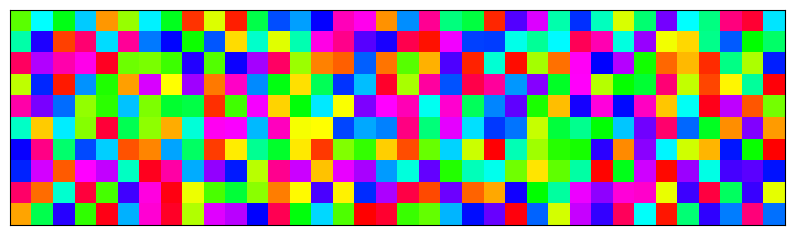

In [124]:
# Create colormap
n_colors = 360
q = n_colors // 6
p = np.linspace(0, 1, q)
w = np.zeros(n_colors + 2*q)
w[2*q:3*q] = p
w[3*q:5*q] = 1.0
w[5*q:6*q] = 1.0 - p
colormap = 255 * np.array([(1.0 - w[q:-q]), w[:-2*q], w[2*q:]]).T
np.random.shuffle(colormap)

# Display colormap as image
imheight = 10
imscale = 1
imwidth = n_colors // imheight
x, y = np.meshgrid(np.arange(imwidth), np.arange(imheight))
image = colormap[(y*imwidth + x),:].astype(np.uint8)
rc_params = {
    'figure.figsize': (imheight*imscale, imwidth*imscale),
    'xtick.bottom': False,
    'xtick.labelbottom': False,
    'ytick.left': False,
    'ytick.labelleft': False
}
with plt.rc_context(rc_params):
    plt.imshow(image)
    plt.show()

# Convert colormap to list of tuples
colormap = list(map(tuple, colormap))

Now we'll run SIFT detection to find all keypoints and descriptors in the frame.

Since I'm working on my own tracking algorithm, I'll use my own keypoint drawing system using the custom colormap above.

In [143]:
keypoints_file = intermediate_file_template.format(step='keypoints')

def draw_keypoints(img, keypoints, colors=cycle(colormap)):
    kpimg = img.copy()
    for kp, color in zip(keypoints, colors):
        r = int(kp.size / 2)
        c = np.array(kp.pt, dtype=np.int32)
        v = np.array([ np.cos(kp.angle), np.sin(kp.angle) ])
        u = (c + r*v).astype(np.uint32)
        cv2.circle(kpimg, c, r, color, 1)
        cv2.arrowedLine(kpimg, c, u, color, 1)
    return kpimg
        
sift = cv2.SIFT.create()
keypoint_data = []

with video_pipe(grayscale_file, keypoints_file) as (cap, wrt):
    for frame in frame_iter(cap, desc="Getting Keypoint Data"):
        keypoints, descriptors = sift.detectAndCompute(frame, track_mask)
        keypoint_data.append((keypoints, descriptors))
        keypoints_frame = draw_keypoints(frame, keypoints)
        wrt.write(keypoints_frame)
        
Video(keypoints_file)

Getting Keypoint Data:   0%|          | 0/750 [00:00<?, ?it/s]

If we look at these keypoints, we notice they're jittering a lot. That's because each frame is treated independently, and each detection is treated as a new keypoint. We need to correlate each keypoint in a frame with the keypoints in the frame before using a matching algorithm.

We'll use the euclidean distance to match the descriptors of keypoints with each other. For each pair of adjacent frames, we take both sets of descriptors, and determine which keypoints match with the previous frame, and which keypoints are new. We can use a distance treshold value to determine these. If keypoints are more similar i.e. low distance, they're correlated. Likewise, if a keypoint's distance is far enough from all other keypoints in the previous frame, it is considered a new keypoint.

We'll keep this data in a dict, with the keys being a set of ID's assigned to each keypoint track, and the value being a list of keypoint datas indicating a track.

In [161]:
tracked_file = intermediate_file_template.format(step='tracked')

track_threshold = 10

@dataclass
class TrackDatapoint:
    descriptor: np.ndarray
    keypoint: cv2.KeyPoint
    
@dataclass
class Track:
    uuid: UUID = field(default_factory=uuid)
    start_frame: int = 0
    track: list[TrackDatapoint] = field(default_factory=list)

    @property
    def end_frame(self):
        return self.start_frame + len(self.track) - 1
    
    @property
    def latest(self):
        return self.track[-1]
    
class TracksDB:
    def __init__(self):
        self.db = OrderedDict()
        
    def new_track(self, frame_idx, dsc, kp):
        dp_obj = TrackDatapoint(descriptor=dsc, keypoint=kp)
        track_obj = Track(start_frame=frame_idx,
                          track=[dp_obj])
        self.db[track_obj.uuid] = track_obj
        
    def tracks_for_frame(self, frame_idx):
        return filter(
            lambda t: t.end_frame == frame_idx,
            self.db.values()
        )
    
    def add_datapoint(self, tid, dsc, kp):
        dp_obj = TrackDatapoint(descriptor=dsc, keypoint=kp)
        self.db[tid].track.append(dp_obj)
        

tracks_db = TracksDB()


def match_descriptors(dsc_a, dsc_b):
    dsc_a = dsc_a[:,np.newaxis,:]
    dsc_b = dsc_b[np.newaxis,:,:]
    dst = np.sum((dsc_b - dsc_a)**2, axis=2)
    return dst.argmin(axis=1), dst.min(axis=1)

kps_0, dsc_0 = keypoint_data[0]
for kp, dsc in zip(kps_0, dsc_0):
    tracks_db.new_track(0, dsc, kp)
    
kp_iterator = tqdm(
    enumerate(keypoint_data[1:]), 
    desc='Creating Tracks', 
    total=len(keypoint_data)-1)
    
for j, (kps_list, current_dsc) in take(50, kp_iterator):
    try:
        i = j + 1

        # Get last track ids and descriptors for frame
        current_kps = np.array(kps_list)
        last_track_ids = np.array([ t.uuid for t in tracks_db.tracks_for_frame(j) ])
        last_track_dsc = np.array([ t.latest.descriptor for t in tracks_db.tracks_for_frame(j) ])
        
        # If we have any tracks
        if last_track_dsc.shape[0] > 0:
            # Match current descriptors with last descriptors and find the 
            # minimum distance. We then use this to find which descriptors 
            # correspond to new keypoints and which ones correspond to 
            # keypoints we've already seen and create masks for each
            m_idx, m_dst = match_descriptors(current_dsc, last_track_dsc)
            tracked = m_dst < track_threshold
            print(last_track_dsc.shape[0], *np.unique(tracked, return_counts=True))
            new_track = ~tracked

            # For tracked keypoints, we'll associate the new keypoints 
            # and descriptors with their corresponding ids. Then add 
            # those new track values to the database
            tracked_kps = current_kps[tracked]
            tracked_dsc = current_dsc[tracked]
            tracked_ids = last_track_ids[m_idx[tracked]]
            for tid, dsc, kp in zip(tracked_ids, tracked_dsc, tracked_kps):
                tracks_db.add_datapoint(tid, dsc, kp)
                
            # We'll create new tracks for new keypoints starting 
            # at current frame
            new_kps = current_kps[new_track]
            new_dsc = current_dsc[new_track]
            for dsc, kp in zip(new_dsc, new_kps):
                tracks_db.new_track(i, dsc, kp)
        else:
            # Add all current keypoints and descriptors as new tracks
            for dsc, kp in zip(current_dsc, current_kps):
                tracks_db.new_track(i, dsc, kp)
                
    except Exception as e:
        print(list(tracks_db.tracks_for_frame(j)))
        print(last_track_dsc.shape)
        print(current_dsc.shape)
        raise e
        
print(len(tracks_db.db.values()))
        
# Assign colors to ids
colors_for_ids = {
    track.uuid: color
    for track, color 
    in zip( tracks_db.db.values(), cycle(colormap) )
}

with video_pipe(grayscale_file, tracked_file) as (cap, wrt):
    for i,frame in take(50, enumerate(frame_iter(cap))):
        tracks = list(tracks_db.tracks_for_frame(i))
        kps = [ track.latest.keypoint for track in tracks ]
        colors = [ colors_for_ids[track.uuid] for track in tracks ]
        tracked_frame = draw_keypoints(frame, kps, colors)
        wrt.write(tracked_frame)
        
Video(tracked_file)        

Creating Tracks:   0%|          | 0/749 [00:00<?, ?it/s]

550 [False  True] [196 360]
556 [False  True] [592   9]
601 [False  True] [627  12]
639 [False  True] [605   3]
608 [False  True] [624   9]
633 [False  True] [616  18]
634 [False  True] [587  48]
635 [False  True] [541  72]
613 [False  True] [586  47]
633 [False  True] [610  39]
649 [False  True] [631  42]
673 [False  True] [627  24]
651 [False  True] [625  26]
651 [False  True] [553 107]
660 [False  True] [550  94]
644 [False  True] [556  97]
653 [False  True] [539 111]
650 [False  True] [480 180]
660 [False  True] [453 197]
650 [False  True] [448 206]
654 [False  True] [344 307]
651 [False  True] [302 367]
669 [False  True] [277 388]
665 [False  True] [314 349]
663 [False  True] [636  24]
660 [False  True] [469 211]
680 [False  True] [324 350]
674 [False  True] [336 345]
681 [False  True] [358 321]
679 [False  True] [331 345]
676 [False  True] [312 366]
678 [False  True] [352 335]
687 [False  True] [285 399]
684 [False  True] [226 448]
674 [False  True] [251 435]
686 [False  True] [2

Processing Frames:   0%|          | 0/750 [00:00<?, ?it/s]